# Processing of triggerlessly acquired detector's data
## PREPROCESSING

Load and prepare the dataset inside a Pandas' DataFrame.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

%matplotlib inline

Inside each directory there are several files related to different test. Now we want to merge all of them into the same DataFrame.

In [5]:
# Load the entire dataset inside the directory
# List all files inside the directory
# Run000260, Run000261, Run000333
directory = "/data/Run000260/"
file_names = [file for file in listdir(directory) if isfile(join(directory, file))]

# Create dataframe by appending the data from each file
data = pd.read_csv(directory + file_names[0])
for i in range(1, len(file_names)):
    data = data.append(pd.read_csv(directory + file_names[i]))
data.shape

KeyboardInterrupt: 

In [7]:
## TEST ONLY
# Prepare the path to the file
directory = "/data/Run000260/"
file_name = "data_000000.txt"

# Load the dataset
data = pd.read_csv(directory + file_name)

In [8]:
# Useful constants
Tmax = 390 # ns
L = 42 # mm
Vd = L/(2*Tmax) # mm/ns
pos_offset = 21 # mm

# Add column of time (ns)
# There is a problem with the precision of the measures, so we drop the orbit
# Real time: data['TIME_NS'] = data["ORBIT_CNT"]*3564*25 + data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30
data['TIME_NS'] = data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30

# Show first 5 rows
data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,1,116,1897414884,1533,24,38345.000000
1,1,1,71,1897414887,1650,21,41267.500000
2,1,1,67,1897414914,980,8,24506.666667
3,1,1,70,1897414922,1287,8,32181.666667
4,1,0,57,1897414922,2162,22,54068.333333


To compute the constant $t_0$, which is different for every event, we can use the following relation:
$$T_{MAX}=\frac{t_{1}+t_{3}}{2}+t_{2}$$
where $t_1 = t_{R_1}-t_0$, $t_2 = t_{R_2}-t_0$ and $t_3 = t_{R_3}-t_0$. Then the relation become:
$$T_{MAX}=\frac{t_{R_1}-t_0+t_{R_3}-t_0}{2}+t_{R_2}-t_0$$
from which we get:
$$t_0=\frac{t_{R_1}+t_{R_3}+2t_{R_2}-2T_{MAX}}{4}$$
Finally we notice that $t_{R_1}$, $t_{R_2}$, $t_{R_3}$ are the times recorded by each cell, which are already available in our dataset.

Before processing the dataset, we have to create some missing columns, in fact the DataFrame with the events must contain the following information:
* CHAMBER, which is the Detector number [1-4];
* LAYER, which is the layer of the cell [1-4];
* CELL, which is in the number of the cell [1-16]; 
* POSTION, which is the position where a particle traverses the cell [0-21] (in mm). 

### Column of LAYER
To get the layer we can compute the remainder of the TDC_CHANNEL with 4 (total number of layers), and then we have to remap the values in the following way:

| REMAINDER | LAYER |
|-----------|-------|
| 0         | 1     |
| 1         | 4     |
| 2         | 2     |
| 3         | 3     |


In [9]:
# To get the layer we must get the remainder of the TDC_CHANNEL with 4
# Then we must reoder the result as described above
data['LAYER'] = data['TDC_CHANNEL'] % 4

# Map 1 --> 4
data.loc[data['LAYER'] == 1,'LAYER'] = 4

# Map 0 -> 1
data.loc[data['LAYER'] == 0,'LAYER'] = 1

# Check the correctness
data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER
0,1,1,116,1897414884,1533,24,38345.000000,1
1,1,1,71,1897414887,1650,21,41267.500000,3
2,1,1,67,1897414914,980,8,24506.666667,3
3,1,1,70,1897414922,1287,8,32181.666667,2
4,1,0,57,1897414922,2162,22,54068.333333,4


### Column of CHAMBER
Create the column for the chamber according to the following rules:
* Detector 1 $\rightarrow$ FPGA 0, TDC_CHANNEL in [1-64]
* Detector 2 $\rightarrow$ FPGA 0, TDC_CHANNEL in [65-128]
* Detector 3 $\rightarrow$ FPGA 1, TDC_CHANNEL in [1-64]
* Detector 4 $\rightarrow$ FPGA 1, TDC_CHANNEL in [65-128]


In [10]:
# Create column for chamber
# Before create empty column
data['CHAMBER'] = 0

# Detector 1
# Select all rows with FPGA = 0 and TDC_CHANNEL <= 64
data.loc[(data['FPGA'] == 0) & (data['TDC_CHANNEL'] <= 64),'CHAMBER'] = 1

# Detector 2
# Select all rows with FPGA = 0 and  64 < TDC_CHANNEL <= 128
data.loc[(data['FPGA'] == 0) & (data['TDC_CHANNEL'] > 64) & (data['TDC_CHANNEL'] <= 128),'CHAMBER'] = 2

# Detector 3
# Select all rows with FPGA = 1 and TDC_CHANNEL <= 64
data.loc[(data['FPGA'] == 1) & (data['TDC_CHANNEL'] <= 64), 'CHAMBER'] = 3

# Detector 4
# Select all rows with FPGA = 0 and  64 < TDC_CHANNEL <= 128
data.loc[(data['FPGA'] == 1) & (data['TDC_CHANNEL'] > 64) & (data['TDC_CHANNEL'] <= 128),'CHAMBER'] = 4

# Check the correctness
data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER
0,1,1,116,1897414884,1533,24,38345.000000,1,4
1,1,1,71,1897414887,1650,21,41267.500000,3,4
2,1,1,67,1897414914,980,8,24506.666667,3,4
3,1,1,70,1897414922,1287,8,32181.666667,2,4
4,1,0,57,1897414922,2162,22,54068.333333,4,1


### Column of CELL
This conlumn contains the values from 1 to 16. These values can be obtained as follows:
$$\lceil{\frac{N_{CHANNEL}\%64}{4}}\rceil$$

In [11]:
# Create column for chamber
data['CELL'] = ((data['TDC_CHANNEL']%64)/4).apply(np.ceil).astype(int)

# Check the correctness
data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL
0,1,1,116,1897414884,1533,24,38345.000000,1,4,13
1,1,1,71,1897414887,1650,21,41267.500000,3,4,2
2,1,1,67,1897414914,980,8,24506.666667,3,4,1
3,1,1,70,1897414922,1287,8,32181.666667,2,4,2
4,1,0,57,1897414922,2162,22,54068.333333,4,1,15


## PART 1
The dataset is ready to be processed, so we can start detecting the events through the trigger 139.

In [12]:
# Silence warning
pd.options.mode.chained_assignment = None  # default='warn'

# Search all the orbit with the trigger 139
orbit = data.loc[data['TDC_CHANNEL'] == 139,'ORBIT_CNT']
list_orbit = orbit.values.tolist()
events = data.loc[data['ORBIT_CNT'].isin(list_orbit)]

# Sort data
events = events.sort_values(by = ['ORBIT_CNT','TDC_CHANNEL'])
events.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL
5,1,0,24,1897414934,2014,13,50360.833333,1,1,6
6,1,0,26,1897414934,2014,20,50366.666667,2,1,7
7,1,0,26,1897414934,2026,13,50660.833333,2,1,7
10,1,0,27,1897414934,2024,11,50609.166667,3,1,7
11,1,0,29,1897414934,2026,9,50657.500000,4,1,8


### Computation of $t_0$
To compute $t_0$ we have to apply the Talete's equation to the cell alignment inside our dataset.
We will limit our search to the following patterns inside the 'LAYER' column:
* 1, 2, 3
* 2, 3, 4

This process can be easily generalized to other patterns.

In [14]:
# Remove the trigger 139
events = events[events['TDC_CHANNEL']<129]

# Make three shifted copy of the LAYER column nd of TIME_NS
events['LAYER_1'] = events['LAYER'].shift(-1)
events['LAYER_2'] = events['LAYER'].shift(-2)
events['TIME_NS_1'] = events['TIME_NS'].shift(-1)
events['TIME_NS_2'] = events['TIME_NS'].shift(-2)

# Search pattern to get the real t0
mask_pattern_1 = (events['LAYER']==1) & (events['LAYER_1']==2) & (events['LAYER_2']==3)
mask_pattern_2 = (events['LAYER']==2) & (events['LAYER_1']==3) & (events['LAYER_2']==4)
mask_pattern = mask_pattern_1 | mask_pattern_2

# Search pattern 1-2-3 or 2-3-4 to apply the Talete's Theorem for t0
events.loc[mask_pattern, 't0'] = (events['TIME_NS'] + events['TIME_NS_2'] + 2*events['TIME_NS_1'] - 2*Tmax)/4

# Populate values of adiacent cell (according to the choosen pattern)
events = events.fillna(0)
events['t0'] = events['t0'] + events['t0'].shift(1) + events['t0'].shift(2)
events = events.fillna(0)

events.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,t0
5,1,0,24,1897414934,2014,13,50360.833333,1,1,6,2.0,2.0,50366.666667,50660.833333,0.000000
6,1,0,26,1897414934,2014,20,50366.666667,2,1,7,2.0,3.0,50660.833333,50609.166667,0.000000
7,1,0,26,1897414934,2026,13,50660.833333,2,1,7,3.0,4.0,50609.166667,50657.500000,50439.166667
10,1,0,27,1897414934,2024,11,50609.166667,3,1,7,4.0,4.0,50657.500000,50661.666667,50439.166667
11,1,0,29,1897414934,2026,9,50657.500000,4,1,8,4.0,2.0,50661.666667,70072.500000,50439.166667


### Column POSITION
Only at this point we can create the column with the position, thanks to $t_0$.

In [15]:
# Compute the position
events.loc[events['t0']!=0,'POSITION'] = (events['TIME_NS'] - events['t0'])*Vd
events = events.fillna(0)

events.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,t0,POSITION
5,1,0,24,1897414934,2014,13,50360.833333,1,1,6,2.0,2.0,50366.666667,50660.833333,0.000000,0.000000
6,1,0,26,1897414934,2014,20,50366.666667,2,1,7,2.0,3.0,50660.833333,50609.166667,0.000000,0.000000
7,1,0,26,1897414934,2026,13,50660.833333,2,1,7,3.0,4.0,50609.166667,50657.500000,50439.166667,11.935897
10,1,0,27,1897414934,2024,11,50609.166667,3,1,7,4.0,4.0,50657.500000,50661.666667,50439.166667,9.153846
11,1,0,29,1897414934,2026,9,50657.500000,4,1,8,4.0,2.0,50661.666667,70072.500000,50439.166667,11.756410


In [64]:
# Map obit values to a range of int
grouped_orbit = events.groupby('ORBIT_CNT')
# Search all orbits
orbits = list(grouped_orbit.groups.keys())
# Create increasing number list for the events
event_number = np.arange(1, len(orbits)+1)
# Create the map
event_map = dict(zip(orbits, event_number))
# Map values
orbit_to_map = events['ORBIT_CNT']
orbit_mapped = orbit_to_map.map(event_map)
events['EVENT_NUMBER'] = orbit_mapped
events.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,temp,t0,POSITION,EVENT_NUMBER
5,1,0,24,1897414934,2014,13,50360.833333,1,1,6,2.0,2.0,50366.666667,50660.833333,50243.750000,0.000000,0.000000,1
6,1,0,26,1897414934,2014,20,50366.666667,2,1,7,2.0,3.0,50660.833333,50609.166667,50379.375000,0.000000,0.000000,1
7,1,0,26,1897414934,2026,13,50660.833333,2,1,7,3.0,4.0,50609.166667,50657.500000,50439.166667,50439.166667,11.935897,1
10,1,0,27,1897414934,2024,11,50609.166667,3,1,7,4.0,4.0,50657.500000,50661.666667,50451.458333,50439.166667,9.153846,1
11,1,0,29,1897414934,2026,9,50657.500000,4,1,8,4.0,3.0,50661.666667,50700.000000,50475.208333,50439.166667,11.756410,1


In [65]:
# Remove unexpected values of the position
events.loc[(events['POSITION']<0) | (events['POSITION']>=21), 'POSITION'] = 0

In [66]:
# Final DataFrame
events_final = events[['EVENT_NUMBER','CHAMBER','LAYER','CELL','POSITION']]
events_final.set_index(['EVENT_NUMBER','CHAMBER','LAYER'], inplace=True)
events_final.sort_index(inplace=True)
events_final.head(5)

CELL   POSITION
EVENT_NUMBER CHAMBER LAYER                 
1            1       1         6   0.000000
                     2         7   0.000000
                     2         7  11.935897
                     3         7   9.153846
                     4         8  11.756410

In [67]:
events_pattern = events[(events['t0']!=0) & (events['POSITION']!=0)]
events_pattern

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,temp,t0,POSITION,EVENT_NUMBER
7,1,0,26,1897414934,2026,13,50660.833333,2,1,7,3.0,4.0,50609.166667,50657.500000,50439.166667,50439.166667,11.935897,1
10,1,0,27,1897414934,2024,11,50609.166667,3,1,7,4.0,4.0,50657.500000,50661.666667,50451.458333,50439.166667,9.153846,1
11,1,0,29,1897414934,2026,9,50657.500000,4,1,8,4.0,3.0,50661.666667,50700.000000,50475.208333,50439.166667,11.756410,1
139,1,1,41,1897415674,1195,9,29882.500000,4,3,11,3.0,3.0,29950.000000,73346.666667,40587.291667,29661.666667,11.891026,5
229,1,1,10,1897416153,2931,4,73278.333333,2,3,3,3.0,4.0,73375.000000,73652.500000,73225.208333,73225.208333,2.860577,6
243,1,0,86,1897416210,2941,28,73548.333333,2,2,6,3.0,1.0,73749.166667,73512.500000,73444.791667,73225.208333,17.399038,7
342,1,0,74,1897416591,542,12,13560.000000,2,2,3,3.0,4.0,13383.333333,13388.333333,13233.750000,13233.750000,17.567308,13
338,1,0,75,1897416591,535,10,13383.333333,3,2,3,4.0,3.0,13388.333333,13775.000000,13288.750000,13233.750000,8.054487,13
339,1,0,81,1897416591,535,16,13388.333333,4,2,5,3.0,3.0,13775.000000,24880.833333,16259.791667,13233.750000,8.323718,13
365,1,0,4,1897416718,2248,20,56216.666667,1,1,1,2.0,3.0,56009.166667,56079.166667,55883.541667,55883.541667,17.937500,15


# PLOT DISTRIBUTION OF DRIFT TIMES

Text(0.5, 1.0, 'PDF of Drift Times')

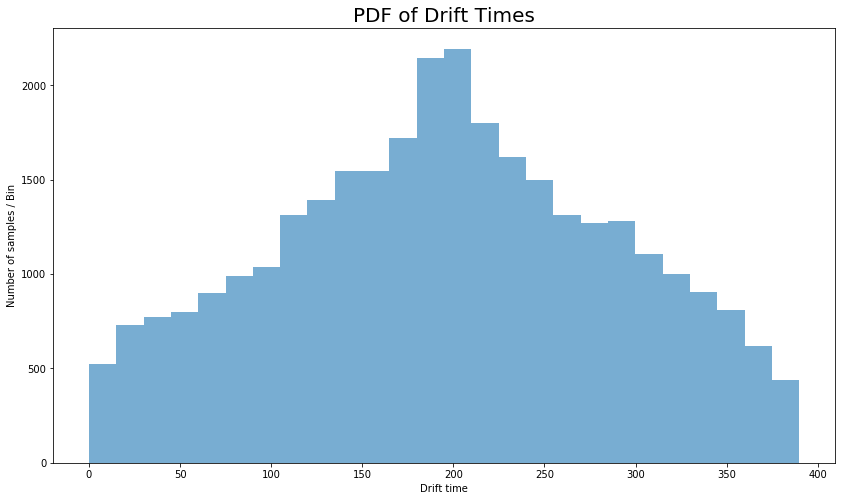

In [92]:
# Get all drift times
drift_times = events_pattern['TIME_NS']-events_pattern['t0']

# Plot PDF
figure = plt.figure(figsize=(14,8))
ax = figure.add_subplot(111)
number_bins = 26
y, edges, bins = ax.hist(drift_times, bins = number_bins, label='PDF', alpha=0.6)
ax.set_ylabel("Number of samples / Bin")
ax.set_xlabel("Drift time")
ax.set_title("PDF of Drift Times", fontsize=20)

## PLOT OF THE DATAFRAME

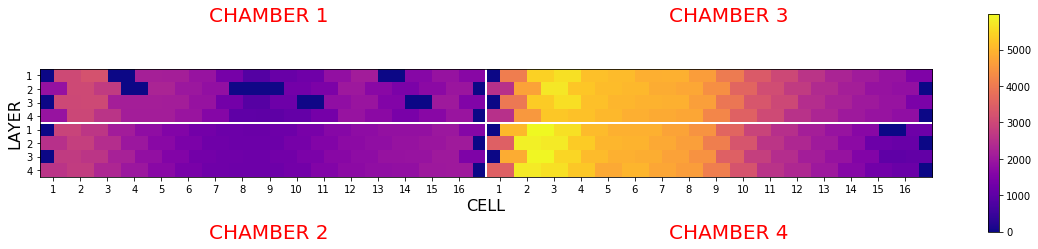

In [12]:
## Visualization of events' hit

# Rebuild the events' dataframe
orbit = data.loc[data['TDC_CHANNEL']==139,'ORBIT_CNT']
list_orbit = orbit.values.tolist()
events = data.loc[data['ORBIT_CNT'].isin(list_orbit)]
events.head(100)


# Remove unreal hits
events = events[events['TDC_CHANNEL']<129]

# Build the hit matrix
raw_mat = np.zeros((16, 32))
rows = np.array((events['CHAMBER']-1)*4+events['LAYER']-1)
columns = np.array((events['CELL']-1)*2).astype(int)

for i in range(len(rows)):
    raw_mat[rows[i], columns[i]] = raw_mat[rows[i], columns[i]]+1
    raw_mat[rows[i], columns[i]+1] = raw_mat[rows[i], columns[i]+1]+1

# Reshape the hit matrix
final_mat = np.zeros((8, 66))

# Chamber 1,2
for i in range(8):
    if (i%2 == 0):
        final_mat[i, 1:33] = raw_mat[i, :32]
    else:
        final_mat[i, :32] = raw_mat[i, :32]     
# Chamber 3,4
for i in range(8, 16):
    if (i%2 == 0):
        final_mat[i-8, 34:66] = raw_mat[i, :32]
    else:
        final_mat[i-8, 33:65] = raw_mat[i, :32]


# Showing the resutls
plt.figure(figsize=(20,4))        
ax = plt.imshow(final_mat, cmap='plasma')

plt.annotate('CHAMBER 1',xy=(0.5, 0.5), xytext=(12,-4), fontsize=20, color='red')
plt.annotate('CHAMBER 2',xy=(0.5, 0.5), xytext=(12,12), fontsize=20, color='red')
plt.annotate('CHAMBER 3',xy=(0.5, 0.5), xytext=(46,-4), fontsize=20, color='red')
plt.annotate('CHAMBER 4',xy=(0.5, 0.5), xytext=(46,12), fontsize=20, color='red')

plt.axvline(x=32.5, color='white', linewidth=2)
plt.axhline(y=3.5, color='white', linewidth=2)

plt.xticks(np.concatenate((np.arange(0.5, 32, 2 ), np.arange(33.5, 65, 2))),
           ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16',
            '1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'])
plt.yticks([x for x in range(8)], ['1','2','3','4','1','2','3','4'])
plt.ylabel('LAYER', fontsize=16)
plt.xlabel('CELL', fontsize=16)
plt.colorbar()

# CODICE VECCHIO (NON CANCELLARE)

In [10]:
## continuiamo col procedimento vecchio per la seconda parte

events_final = pd.DataFrame(columns=['ORBIT','CHAMBER','LAYER','CELL'])

gr_events = events.groupby('ORBIT_CNT')

c = 0
for orb, gr in gr_events:
    events_final.loc[c] = [orb, np.array(gr['CHAMBER']), np.array(gr['LAYER']), np.array(gr['CELL'])]
    c+=1    
events_final.head()

KeyboardInterrupt: 

In [47]:
## INIZIO SEZZIONE TEST

grouped_orbit = data.groupby('ORBIT_CNT')
triggered_orbit = grouped_orbit.filter(lambda x: x['TDC_CHANNEL'].max()==139)
## Triggered_orbit è un dataframe contente tutti gli hit delle orbit che hanno il trigger 139
## Ci mette molto anche usando filter (meno di 5 minuti però, credo...)
triggered_orbit.head()
## Le orbit sembrano già essere in ordine crescente

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL
5,1,0,24,1897414934,2014,13,50360.833333,1,1,3.0
6,1,0,26,1897414934,2014,20,50366.666667,2,1,4.0
7,1,0,26,1897414934,2026,13,50660.833333,2,1,4.0
8,1,0,139,1897414934,2028,0,50700.000000,3,0,18.0
9,1,0,33,1897414934,2026,14,50661.666667,4,1,5.0


In [49]:
## Lets costruiamo questo fucking dataframe
events = pd.DataFrame(columns=['ORBIT','CHAMBER','LAYER','CELL'])

## Eliminiamo le hit corrispondenti ai trigger
triggered_orbit = triggered_orbit[triggered_orbit['TDC_CHANNEL']<137]
gr_event = triggered_orbit.groupby('ORBIT_CNT')
 
## Ocio che ci mette molto tempo
c = 0
for orb, gr in gr_event:
    events.loc[c] = [orb, np.array(gr['CHAMBER']), np.array(gr['LAYER']), np.array(gr['CELL'])]
    c+=1    
events.head()
## FUCK YEAH!

,ORBIT,CHAMBER,LAYER,CELL
0,1897414934,"[1, 1, 1, 1, 1, 1]","[1, 2, 2, 4, 3, 4]","[3, 4, 4, 5, 4, 4]"
1,1897415301,"[2, 2, 2, 2]","[2, 3, 1, 4]","[11, 11, 11, 12]"
2,1897415425,"[3, 3, 3, 3]","[3, 1, 2, 4]","[4, 4, 5, 5]"
3,1897415544,"[4, 4, 4, 4]","[1, 3, 4, 2]","[12, 12, 12, 12]"
4,1897415674,"[3, 3, 3, 3, 3]","[1, 4, 4, 2, 3]","[5, 6, 3, 5, 5]"


In [ ]:
## Adesso voglio provare a visualizzare i risultati: ogni chamber sarà una matrice 32x132
## --> 4 righe di altezza, 16 di larghezza
## Comincio da una matrice nulla, sommo 1 alla cella in cui ho l'hit
## Devo ricordarmi che ho gli strati sfalsati, con riferimento all'immagine
## --> Conviene riempire la matrice normalmente lasciando libera l'ultima "mezza cella", e poi shiftare i risultati
mat_ch1 = mat_ch2 = mat_ch3 = mat_ch4 = np.zeros((32,132))

In [10]:
## TUTTO OK FINO A QUA
# Create DataFrame for the event
events = pd.DataFrame(columns=['ORBIT','CHAMBER','LAYER','CELL','POSITION'])

# Sort data according their orbit and their cell
data_sorted = data.sort_values(by = ['ORBIT_CNT','TDC_CHANNEL'])


# VERY SLOW
pattern = [1,2,3,4]
data_sorted.rolling(len(pattern)).apply(lambda x: all(np.equal(x, pattern)))
matched = matched.sum(axis = 1).astype(bool)
print(matched)

,HEAD,FPGA,CELL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER
0,1,1,116,1897414884,1533,24,38345.000000,1
1,1,1,71,1897414887,1650,21,41267.500000,3
2,1,1,67,1897414914,980,8,24506.666667,3
4,1,0,57,1897414922,2162,22,54068.333333,4
3,1,1,70,1897414922,1287,8,32181.666667,2
5,1,0,24,1897414934,2014,13,50360.833333,1
6,1,0,26,1897414934,2014,20,50366.666667,2
7,1,0,26,1897414934,2026,13,50660.833333,2
10,1,0,27,1897414934,2024,11,50609.166667,3
11,1,0,29,1897414934,2026,9,50657.500000,4


In [8]:
# Now I can group hits according to the orbit
grouped_orbit = data.groupby(['ORBIT_CNT'])

index = 0
# At this point all the hits are grouped according to their orbit,
# so we have to distinguish which of them form an event
for key, group in grouped_orbit: # For every group
    # Check if there is the trigger inside the hits group
    flag = group['CELL'] == 139;
    # If there are more than 5 hits and there is the trigger
    if group.shape[0] >= 5 and flag.any():
        # Sort group by cell number
        group.sort_values(by = 'CELL')
        index += 1

KeyboardInterrupt: 

## PART 2
Now we have to find the events without the help of the trigger (139) and to do so we will use the mean time trigger as follow

In [8]:
# CAVEAT:
# This method can fail if there is a lot of noise
# Sort the DataFrame
data = data.sort_values(by = ['ORBIT_CNT','TDC_CHANNEL'])

# TODO: Remove all the triggers 137, 138, 139 

data['T1'] = data['TIME_NS']
data['T2'] = data['TIME_NS'].shift(1)
data['T3'] = data['TIME_NS'].shift(2)

# TODO: Remove rows with NaN

# Compute T 
# TODO: Missing t0
data['T0'] = (data['T1'] - data['T3'])/2 + data['T2'] - Tmax

# Look for T = Tmax and there there will be an event

data.head(20)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,T1,T2,T3,T0
0,1,1,116,1897414884,1533,24,38345.000000,1,4,38345.000000,NaN,NaN,NaN
1,1,1,71,1897414887,1650,21,41267.500000,3,4,41267.500000,38345.000000,NaN,NaN
2,1,1,67,1897414914,980,8,24506.666667,3,4,24506.666667,41267.500000,38345.000000,33958.333333
4,1,0,57,1897414922,2162,22,54068.333333,4,1,54068.333333,24506.666667,41267.500000,30517.083333
3,1,1,70,1897414922,1287,8,32181.666667,2,4,32181.666667,54068.333333,24506.666667,57515.833333
5,1,0,24,1897414934,2014,13,50360.833333,1,1,50360.833333,32181.666667,54068.333333,29937.916667
6,1,0,26,1897414934,2014,20,50366.666667,2,1,50366.666667,50360.833333,32181.666667,59063.333333
7,1,0,26,1897414934,2026,13,50660.833333,2,1,50660.833333,50366.666667,50360.833333,50126.666667
10,1,0,27,1897414934,2024,11,50609.166667,3,1,50609.166667,50660.833333,50366.666667,50392.083333
11,1,0,29,1897414934,2026,9,50657.500000,4,1,50657.500000,50609.166667,50660.833333,50217.500000


In [9]:
## Nuova test section
test = triggered_orbit
test = test[test['TDC_CHANNEL']!=139]gr_test = test.groupby('ORBIT_CNT')

c = 0

for orb, gr in gr_test:
    events.loc[c] = [orb, np.array(gr['CHAMBER']), np.array(gr['LAYER']), np.array(gr['CELL']).astype(int)]
    c+=1
    
    
events.head()
    

SyntaxError: invalid syntax (<ipython-input-9-83b0f6ca14d0>, line 3)

In [ ]:
## TEST COSTRUZIONE DATAFRAME OCIO CHE CI METTE TANTISSIMISSIMO (Per ora teniamo quello di Boet)
## Lets costruiamo questo fucking dataframe
events = pd.DataFrame(columns=['EVENT','HIT','INFO','VALUE'])

## Eliminiamo le hit corrispondenti ai trigger
triggered_orbit = triggered_orbit[triggered_orbit['TDC_CHANNEL']<137]
gr_event = triggered_orbit.groupby('ORBIT_CNT')
 
## Ocio che ci mette molto tempo
event_counter = 0
row_counter = 0
for orb, group in gr_event:
    hit_counter = 1
    for row, data in group.iterrows():
        events.loc[row_counter] = [event_counter,hit_counter,'CHAMBER',data['CHAMBER']]
        events.loc[row_counter+1] = [event_counter,hit_counter,'LAYER',data['LAYER']]
        events.loc[row_counter+2] = [event_counter,hit_counter,'CELL',data['CELL']]
        events.loc[row_counter+3] = [event_counter,hit_counter,'POSITION',1]
        hit_counter += 1
        row_counter += 4
    event_counter += 1    
events.head()
## FUCK YEAH!